In [1]:
%%capture

# For the demonstration, we need torchaudio and matplotlib to process example audios and visualize the spectrogram
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib scipy

In [2]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()


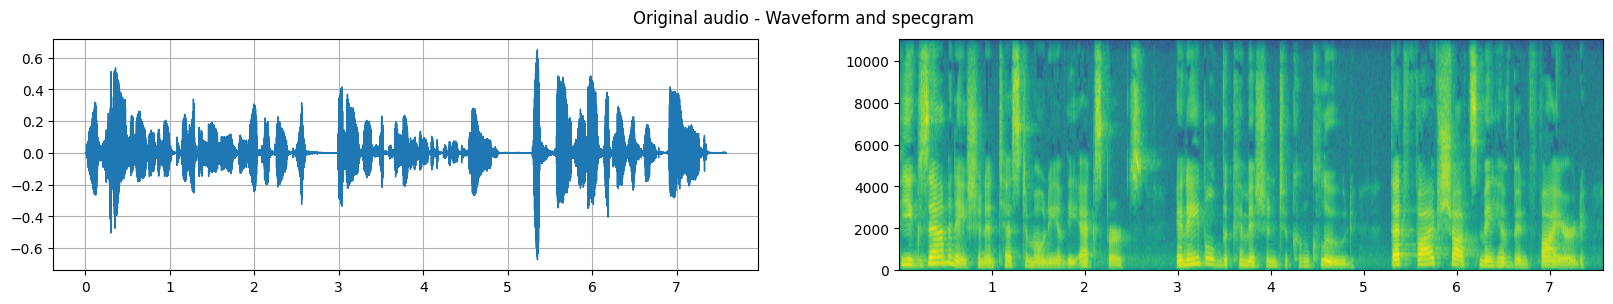

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram

plot_waveform_and_specgram(audio, sr, title="Original audio")

In [4]:
play_audio(audio, sr)

In [5]:
# Initialise Audioseal models
from audioseal import AudioSeal

# Load models
generator = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))


In [6]:
# Generate 4 UNIQUE messages (16-bit)
messages = [torch.randint(0, 2, (1, 16)) for _ in range(4)]
for i, msg in enumerate(messages):
    print(f"Message {i+1}: {msg.numpy().flatten()}")  # Verify uniqueness

# Embed sequentially with reduced alpha
audios = audio.unsqueeze(0)  # Add batch dimension
watermarked_audio = audios.clone()
alpha = 1  

# Calculate snr before to use it later
def calculate_snr(original, watermarked):
    noise = watermarked - original
    return 10 * torch.log10(original.pow(2).mean() / noise.pow(2).mean())

for i, msg in enumerate(messages):
    watermark = generator.get_watermark(watermarked_audio, sample_rate=sr, message=msg)
    watermarked_audio += alpha * watermark
    print(f"Watermark {i+1} embedded. Current SNR: {calculate_snr(audios, watermarked_audio):.2f} dB")

Watermark 1 embedded. Current SNR: 29.33 dB
Watermark 2 embedded. Current SNR: 26.04 dB
Watermark 3 embedded. Current SNR: 24.24 dB


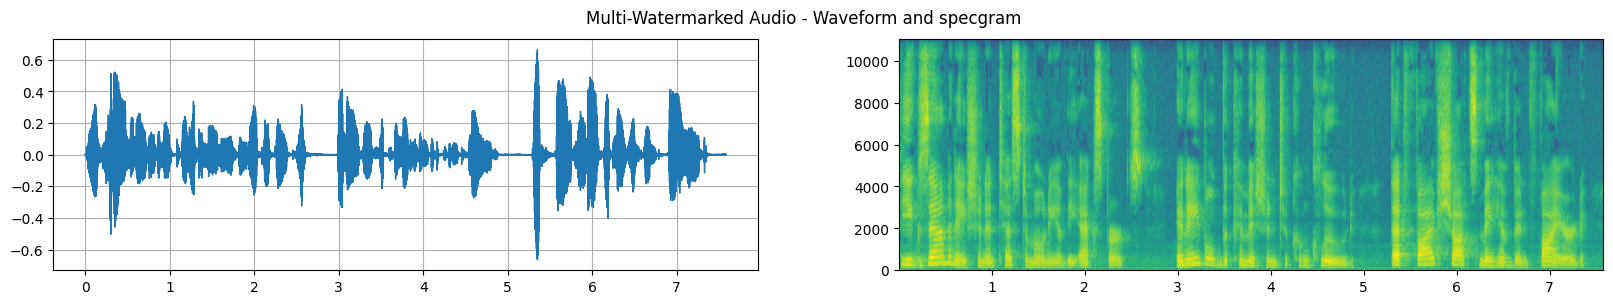

In [7]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Multi-Watermarked Audio")
play_audio(watermarked_audio, sr)

In [8]:
#Detect watermarks
def detect_watermarks(watermarked_audio, messages):
    results = []
    for msg in messages:
        detector.message = msg  # Force detector to look for this message
        prob, decoded_msg = detector.detect_watermark(watermarked_audio, sample_rate=sr)
        ber = (msg != decoded_msg.round()).float().mean()
        results.append((prob, ber))
    return results

In [9]:
# Detect after all embeddings
results = detect_watermarks(watermarked_audio, messages)
print("\n--- Before Attacks ---")
for i, (prob, ber) in enumerate(results):
    print(f"Watermark {i+1}: Detection Prob = {prob:.2f}, BER = {ber:.2f}")


--- Before Attacks ---
Watermark 1: Detection Prob = 1.00, BER = 0.56
Watermark 2: Detection Prob = 1.00, BER = 0.50
Watermark 3: Detection Prob = 1.00, BER = 0.00


In [10]:
#apply attacks
from attacks1 import AudioEffects1 as attacks1
# Apply MP3 compression
attacked_audio = attacks.mp3_compression(watermarked_audio, bitrate=64)

# Detect after attack
attacked_results = detect_watermarks(attacked_audio, messages)
                                    
print("Compressed audio shape:", compressed_audio.shape)
                                     
print("\n--- After MP3 Compression (64 kbps) ---")
for i, (prob, ber) in enumerate(attacked_results):
    print(f"Watermark {i+1}: Detection Prob = {prob:.2f}, BER = {ber:.2f}")

ModuleNotFoundError: No module named 'attacks1'

In [ ]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Multi-Watermarked Audio")
play_audio(watermarked_audio, sr)